# Google Quick Draw Autoencoder

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data_dir = 'data'
name = 'teapot'
size = 28

In [3]:
import ndjson
import numpy as np

data = np.load(f'{data_dir}/{name}.npy').astype(np.float32)
data /= 255.0

n = data.shape[0]

with open(f'{data_dir}/{name}.ndjson') as f:
    strokes = ndjson.load(f)

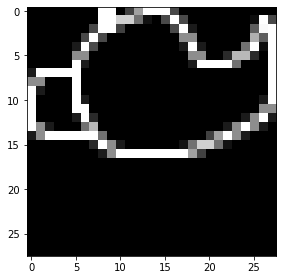

In [4]:
from skimage.io import imshow
from skimage.draw import line_aa

im_num = 1000

scaling = size / 256

sketch = np.zeros((size, size), dtype=np.float64)

for stroke in strokes[im_num]['drawing']:
    xs, ys = stroke
    for k in np.arange(1, len(xs)):            
        i, j, val = line_aa(
            min(27, round(ys[k-1] * scaling)),
            min(27, round(xs[k-1] * scaling)),
            min(27, round(ys[k] * scaling)),
            min(27, round(xs[k] * scaling))
        ) # i0, j0, i1, j1
        sketch[i,j] += val

sketch = np.clip(sketch, 0, 1)

imshow(sketch)

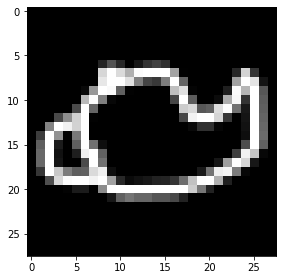

In [5]:
imshow(data[im_num].reshape((size, size)))

## Filter Data

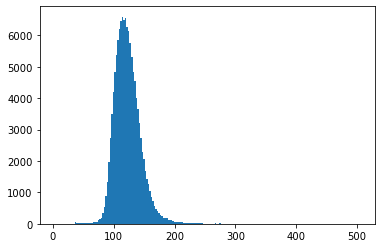

Preselected 124265 out of 126804


In [17]:
from functools import reduce
import matplotlib.pyplot as plt

pixel_sum = data.sum(axis=1)
    
plt.hist(pixel_sum, bins=200)
plt.show()

pixel_sum_lower_end, pixel_sum_upper_end = np.percentile(pixel_sum, [1, 99])

preselection = np.logical_and(pixel_sum > pixel_sum_lower_end, pixel_sum < pixel_sum_upper_end)

data_selected = data[preselection]

n = data_selected.shape[0]

print(f'Preselected {preselection.sum()} out of {data.shape[0]}')

## Create Autoencoder

In [7]:
import ae

encoder, autoencoder = ae.create()

autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 8)           1160      
_________________________________________________________________
conv3 (Conv2D)               (None, 4, 4, 8)           584       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                4128      
_________________________________________________________________
dense2 (Dense)               (None, 16)                528 

In [8]:
permutations = np.random.permutation(n)

subsample = 1.0
train_fraction = 0.9
train = permutations[:int(train_fraction * subsample * n)]
test = permutations[int(train_fraction * subsample * n):int(subsample * n)]

x_train = np.reshape(data_selected[train], (train.size, size, size, 1))
x_test = np.reshape(data_selected[test], (test.size, size, size, 1))

print(f'Total dataset size: {n}')
print(f'Train size: {train.shape[0]}')
print(f'Test size: {test.shape[0]}')

Total dataset size: 144818
Train size: 130336
Test size: 14482


In [9]:
tqdm_keras = ae.get_tqdm(is_keras=True)

autoencoder.fit(
    x_train,
    x_train,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=0,
    callbacks=[tqdm_keras(leave_inner=True, leave_outer=False)],
)

Instructions for updating:
Use tf.cast instead.


In [10]:
encoder.save(f'{data_dir}/{name}-encoder.h5')
autoencoder.save(f'{data_dir}/{name}-autoencoder.h5')

## Encode Images

In [6]:
import keras

encoder = keras.models.load_model(f'{data_dir}/{name}-encoder.h5')
autoencoder = keras.models.load_model(f'{data_dir}/{name}-autoencoder.h5')

Using TensorFlow backend.
/Users/Fritz/miniconda3/envs/pilingjs/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Fritz/miniconda3/envs/pilingjs/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Fritz/miniconda3/envs/pilingjs/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Frit

Instructions for updating:
Colocations handled automatically by placer.


/Users/Fritz/miniconda3/envs/pilingjs/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


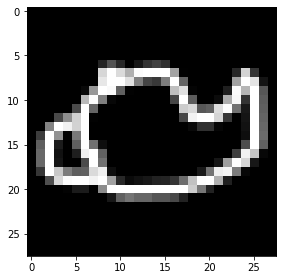

In [7]:
imshow(data[im_num].reshape((size, size)))

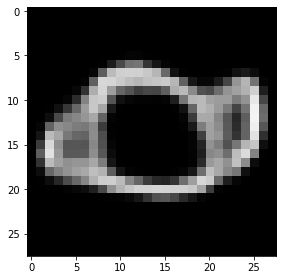

In [8]:
predicted_img = autoencoder.predict(data[im_num].reshape((1, size, size, 1)))
imshow(predicted_img.reshape((size, size)))

In [18]:
encoded_data = encoder.predict(data_selected.reshape((n, size, size, 1)))

In [14]:
np.save(f'{data_dir}/{name}-encoded.npy', encoded_data)

## UMAP Embedding

In [19]:
from umap import UMAP

embeddings = UMAP(n_neighbors=5).fit_transform(encoded_data)
np.save(f'{data_dir}/{name}-encoded-embedded.npy', embeddings)

/Users/Fritz/miniconda3/envs/pilingjs/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pilingjs/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/Fritz/miniconda3/envs/pilingjs/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../minicond

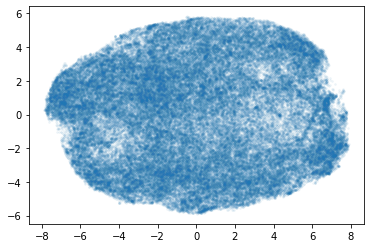

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

embeddings = np.load(f'{data_dir}/{name}-encoded-embedded.npy')

plt.scatter(embeddings[:,0], embeddings[:,1], s=3, alpha=0.05)

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0.05, 0.95))
scaled_embeddings = scaler.fit_transform(embeddings)

## Cluster

In [22]:
from sklearn.cluster import KMeans

embedding_clusters = KMeans(36).fit_transform(embeddings)
centers = np.argmin(embedding_clusters, axis=0)

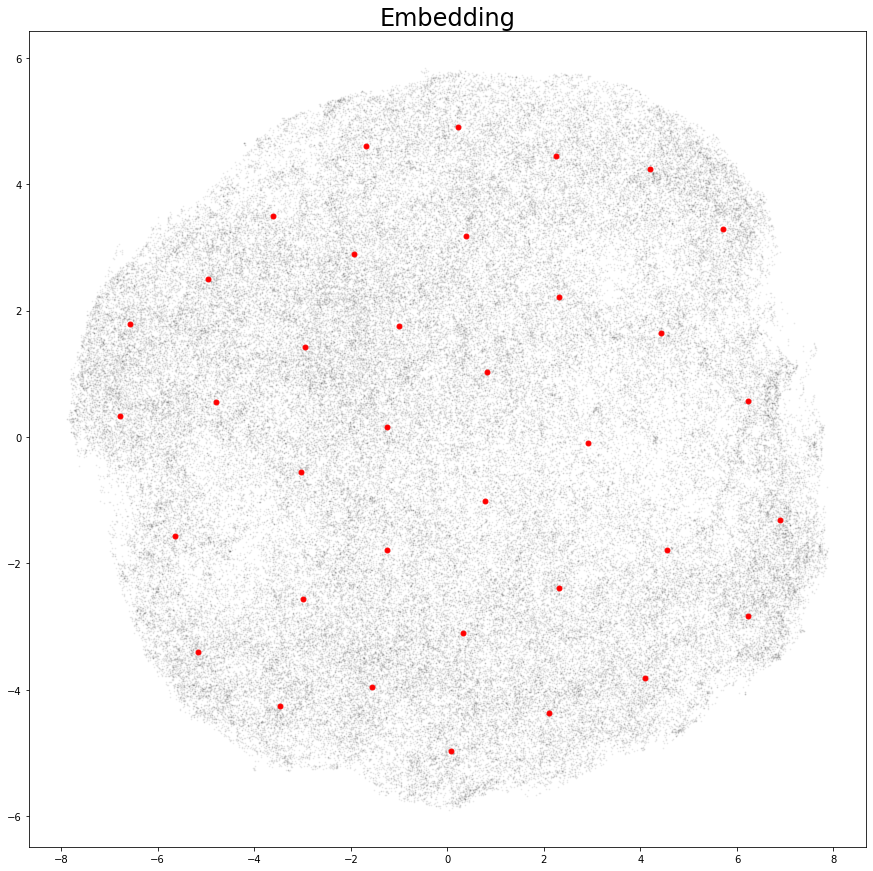

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(embeddings[:,0], embeddings[:,1], s=1, alpha=0.05, color='#000000')
ax.scatter(embeddings[centers,0], embeddings[centers,1], s=24, alpha=1.0, color='#ff0000')
ax.set_title('Embedding', fontsize=24);

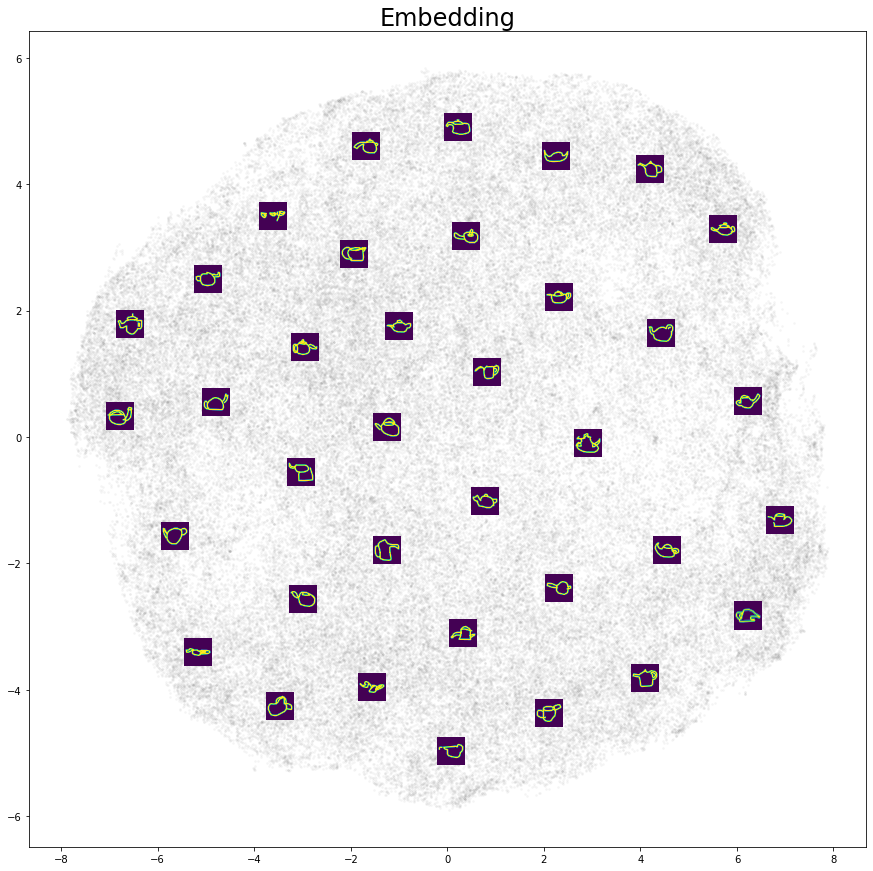

In [24]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(embeddings[:,0], embeddings[:,1], s=3, alpha=0.05, color='#808080')
ax.set_title('Embedding', fontsize=24);

for c in centers:
    ax.add_artist(AnnotationBbox(OffsetImage(data[c].reshape((size, size))), embeddings[c], frameon=False))

## Sub-sampling
#### Submodular function maximization

In [21]:
from apricot import FeatureBasedSelection

selector = FeatureBasedSelection(2000, n_jobs=-1)
_, selection = selector.fit_transform(encoded_data, np.arange(encoded_data.shape[0]))

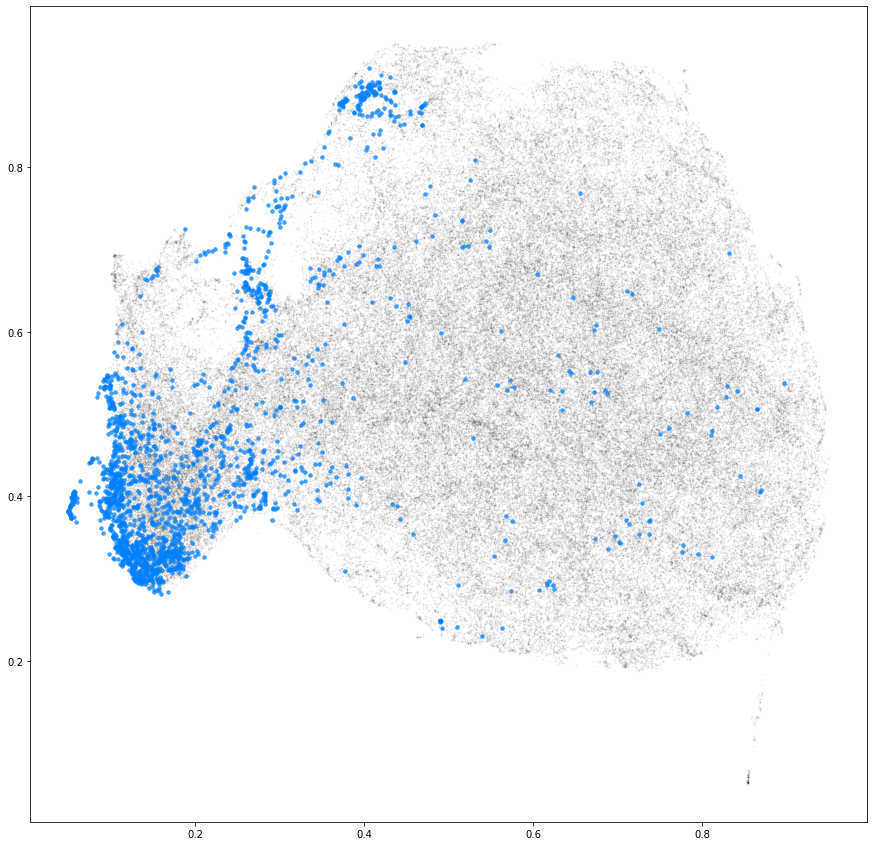

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(scaled_embeddings[:,0], scaled_embeddings[:,1], s=1, alpha=0.05, c='#000000')
ax.scatter(scaled_embeddings[selection,0], scaled_embeddings[selection,1], s=12, alpha=0.66, c='#0080ff')

#### KMeans-based Sampling

In [57]:
from sampling import sample

sampled_points = sample(20, 100, scaled_embeddings)

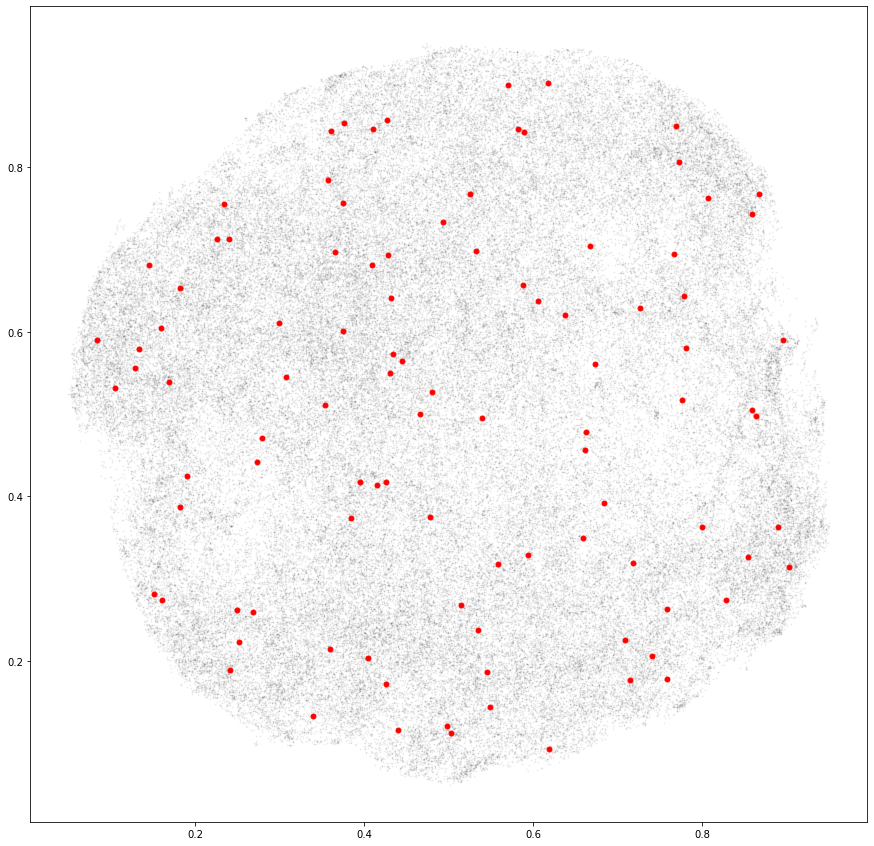

In [58]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(scaled_embeddings[:,0], scaled_embeddings[:,1], s=1, alpha=0.05, c='#000000')
ax.scatter(scaled_embeddings[sampled_points[100:],0], scaled_embeddings[sampled_points[100:],1], s=6, alpha=0.5, c='#0080ff')
ax.scatter(scaled_embeddings[sampled_points[:100],0], scaled_embeddings[sampled_points[:100],1], s=24, alpha=1.0, c='#ff0000')

## Save

In [59]:
import json 

with open('data/country-iso2-to-region.json', 'r') as f:
    country_to_region = json.load(f)

In [60]:
import codecs 

out = []

rel_to_abs_index = np.cumsum(preselection[preselection])

for i in sampled_points:
    abs_i = rel_to_abs_index[i]
    try:
        region = country_to_region[strokes[abs_i]['countrycode']]
    except KeyError:
        region = None
        
    out.append({
        'countryCode': strokes[abs_i]['countrycode'],
        'region': region,
        'recognized': strokes[abs_i]['recognized'],
        'umapEmbedding': scaled_embeddings[i, 0:2].tolist(),
        'src': np.array(strokes[abs_i]['drawing']).tolist(),
    })

with open(f'{data_dir}/{name}-{sampled_points.shape[0]}.json', 'w') as f:
    json.dump(out, f)